# Predictive Modeling for Gold Recovery Optimization in Heavy Industry

# Project Description:

This project aims to develop a prototype of a machine learning model for Zyfra, a company specializing in efficiency solutions for heavy industry. The primary objective is to create a predictive model that can accurately estimate the amount of gold recovered from gold ore, using data on extraction and purification processes. By achieving this, Zyfra intends to optimize its production processes and eliminate unprofitable parameters, ultimately enhancing operational efficiency and profitability.

# Project Goals:

**Data Preparation**: Collect, clean, and preprocess the available data on gold extraction and purification. This step involves handling missing values, outlier detection, and data transformation to make it suitable for machine learning.

**Data Analysis**: Perform exploratory data analysis (EDA) to gain insights into the dataset. Visualize key features to understand the distribution, relationships, and patterns within the data.

**Model Development**: Build a machine learning model that predicts the amount of gold recovered from gold ore based on input features related to extraction and purification processes. The choice of the machine learning algorithm will be made after careful evaluation of the data and model requirements.

**Model Training**: Train the selected machine learning model using the preprocessed data. Employ techniques like cross-validation to assess model performance and fine-tune hyperparameters for optimal results.


# Data Description:
The data is stored in three files:
* gold_recovery_train.csv — training dataset 
* gold_recovery_test.csv — test dataset 
* gold_recovery_full.csv — source  

# Technological Process:

How is gold extracted from ore? Let's look into the process stages.
Mined ore undergoes primary processing to get the ore mixture or rougher feed, which is the raw material for flotation (also known as the rougher process). After flotation, the material is sent to two-stage purification.
image
Let's break down the process:
1. **Flotation**
Gold ore mixture is fed into the float banks to obtain rougher Au concentrate and rougher tails (product residues with a low concentration of valuable metals).
The stability of this process is affected by the volatile and non-optimal physicochemical state of the flotation pulp (a mixture of solid particles and liquid).
2. **Purification**
The rougher concentrate undergoes two stages of purification. After purification, we have the final concentrate and new tails.

**Key Terms**
- Rougher feed — raw material
- Rougher additions (or reagent additions) — flotation reagents: Xanthate, Sulphate, Depressant
    - Xanthate — promoter or flotation activator;
    - Sulphate — sodium sulphide for this particular process;
    - Depressant — sodium silicate.
- Rougher process — flotation
- Rougher tails — product residues
- Float banks — flotation unit
- Cleaner process — purification
- Rougher Au — rougher gold concentrate
- Final Au — final gold concentrate

Parameters of stages

- air amount — volume of air
- fluid levels
- feed size — feed particle size
- feed rate

Feature naming: 
Here's how you name the features:
[stage].[parameter_type].[parameter_name]

Example: rougher.input.feed_ag

Possible values for [stage]:
- rougher — flotation
- primary_cleaner — primary purification
- secondary_cleaner — secondary purification
- final — final characteristics

Possible values for [parameter_type]:
- input — raw material parameters
- output — product parameters
- state — parameters characterizing the current state of the stage
- calculation — calculation characteristics

### Evaluation metric
To solve the problem, we will need a new metric, sMAPE, symmetric Mean Absolute Percentage Error. 

We need to predict two values:

     - rougher concentrate recovery rougher.output.recovery
     - final concentrate recovery final.output.recovery

# Prepare Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from sklearn.model_selection import *
from sklearn.tree import *
from sklearn.ensemble import *
from sklearn.dummy import DummyRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import *
from sklearn.utils import shuffle

In [2]:
#silencing warnings 
import sys
import warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [3]:
# Establishing functions and variables that will be used throughout the project

# Set random state
random_state = 12345

# Define inspection function to get a quick overview of the data
def inspect(df): 
    print("Dataframe info:")
    print(df.info())
    print()
    print("First three rows of dataframe: ")
    print(df.head(3))
    print()
    print("Dataframe describe: ")
    print(df.describe())
    print()
    print("There are", df.duplicated().sum(), "duplicated rows")
    print()
    print("There are", df.isna().sum().sum(), "NaN values in entire DataFrame")
    print()

# Define function to calculate recovery rate
def recovery(df, C, F, T):
    rec = 100 * ((df[C] * (df[F] - df[T])) / (df[F] * (df[C] - df[T])))
    return rec

# Define purify function to calculate the final concentrate
def purify_progress(metal):
    steps = [stage.format(metal) for stage in stages]
    for i in steps:
        full[i].hist(alpha=0.5, bins=20)
    plt.legend(steps, fontsize='small')

# Define sMAPE function
def smape(target, prediction): 
    return (1/len(target)) * sum(abs(prediction - target) / ((abs(target) + abs(prediction)) / 2) * 100)
  
# Defining final_smape function
def final_smape(target, prediction):
    rougher = smape(target[:, 0], prediction[:, 0])
    final = smape(target[:, 1], prediction[:, 1])
    return rougher * 0.25 + final * 0.75

## 1. Load Data

In [4]:
train = pd.read_csv('gold_recovery_train.csv')
test = pd.read_csv('gold_recovery_test.csv')
full = pd.read_csv('gold_recovery_full.csv')

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [6]:
train.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,16788.000000,16788.000000,16490.000000,16789.000000,15339.000000,16794.000000,16677.000000,16715.000000,16794.000000,15553.000000,...,16731.000000,16747.000000,16768.000000,16767.000000,16775.000000,16775.000000,16775.000000,16776.000000,16757.000000,16775.000000
mean,4.716907,9.113559,8.301123,39.467217,67.213166,8.757048,2.360327,9.303932,2.687512,129.479789,...,19.101874,-494.164481,14.778164,-476.600082,15.779488,-500.230146,12.377241,-498.956257,18.429208,-521.801826
std,2.096718,3.389495,3.825760,13.917227,11.960446,3.634103,1.215576,4.263208,1.272757,45.386931,...,6.883163,84.803334,5.999149,89.381172,6.834703,76.983542,6.219989,82.146207,6.958294,77.170888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.021781,-0.423260,-799.741097,0.427084,-800.258209,0.024270,-810.473526
25%,3.971262,8.825748,6.939185,42.055722,62.625685,7.610544,1.641604,7.870275,2.172953,103.064021,...,14.508299,-500.837689,10.741388,-500.269182,10.977713,-500.530594,8.925586,-500.147603,13.977626,-501.080595
50%,4.869346,10.065316,8.557228,44.498874,67.644601,9.220393,2.453690,10.021968,2.781132,131.783108,...,19.986958,-499.778379,14.943933,-499.593286,15.998340,-499.784231,11.092839,-499.933330,18.034960,-500.109898
75%,5.821176,11.054809,10.289741,45.976222,72.824595,10.971110,3.192404,11.648573,3.416936,159.539839,...,24.983961,-494.648754,20.023751,-400.137948,20.000701,-496.531781,15.979467,-498.418000,24.984992,-499.565540
max,16.001945,17.031899,18.124851,53.611374,100.000000,19.552149,6.086532,22.317730,9.789625,251.999948,...,60.000000,-127.692333,28.003828,-71.472472,63.116298,-275.073125,39.846228,-120.190931,54.876806,-39.784927


In [7]:
train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [9]:
test.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5554.000000,5572.000000,5856.000000,5690.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,...,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,170.515243,8.482873,7.264651,1.321420,1481.990241,-509.057796,1486.908670,-511.743956,1468.495216,-509.741212,...,15.636031,-516.266074,13.145702,-476.338907,12.308967,-512.208126,9.470986,-505.017827,16.678722,-512.351694
std,49.608602,3.353105,0.611526,0.693246,310.453166,61.339256,313.224286,67.139074,309.980748,62.671873,...,4.660835,62.756748,4.304086,105.549424,3.762827,58.864651,3.312471,68.785898,5.404514,69.919839
min,0.000103,0.000031,5.650000,0.000003,0.000000,-799.773788,0.000000,-800.029078,0.000000,-799.995127,...,0.000000,-799.798523,0.000000,-800.836914,-0.223393,-799.661076,0.528083,-800.220337,-0.079426,-809.859706
25%,143.340022,6.411500,6.885625,0.888769,1497.190681,-500.455211,1497.150234,-500.936639,1437.050321,-501.300441,...,12.057838,-501.054741,11.880119,-500.419113,10.123459,-500.879383,7.991208,-500.223089,13.012422,-500.833821
50%,176.103893,8.023252,7.259333,1.183362,1554.659783,-499.997402,1553.268084,-500.066588,1546.160672,-500.079537,...,17.001867,-500.160145,14.952102,-499.644328,12.062877,-500.047621,9.980774,-500.001338,16.007242,-500.041085
75%,207.240761,10.017725,7.650000,1.763797,1601.681656,-499.575313,1601.784707,-499.323361,1600.785573,-499.009545,...,18.030985,-499.441529,15.940011,-401.523664,15.017881,-499.297033,11.992176,-499.722835,21.009076,-499.395621
max,274.409626,40.024582,15.500000,5.433169,2212.432090,-57.195404,1975.147923,-142.527229,1715.053773,-150.937035,...,30.051797,-401.565212,31.269706,-6.506986,25.258848,-244.483566,14.090194,-126.463446,26.705889,-29.093593


In [10]:
test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [11]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [12]:
full.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,22627.000000,22629.000000,22331.000000,22630.000000,20753.000000,22633.000000,22516.000000,22445.000000,22635.000000,21107.000000,...,22571.000000,22587.000000,22608.000000,22607.000000,22615.000000,22615.000000,22615.000000,22616.000000,22597.000000,22615.000000
mean,4.781559,9.095308,8.640317,40.001172,67.447488,8.923690,2.488252,9.523632,2.827459,140.277672,...,18.205125,-499.878977,14.356474,-476.532613,14.883276,-503.323288,11.626743,-500.521502,17.976810,-519.361465
std,2.030128,3.230797,3.785035,13.398062,11.616034,3.517917,1.189407,4.079739,1.262834,49.919004,...,6.560700,80.273964,5.655791,93.822791,6.372811,72.925589,5.757449,78.956292,6.636203,75.477151
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.836914,-0.423260,-799.741097,0.427084,-800.258209,-0.079426,-810.473526
25%,4.018525,8.750171,7.116799,42.383721,63.282393,7.684016,1.805376,8.143576,2.303108,110.177081,...,14.095940,-500.896232,10.882675,-500.309169,10.941299,-500.628697,8.037533,-500.167897,13.968418,-500.981671
50%,4.953729,9.914519,8.908792,44.653436,68.322258,9.484369,2.653001,10.212998,2.913794,141.330501,...,18.007326,-499.917108,14.947646,-499.612292,14.859117,-499.865158,10.989756,-499.951980,18.004215,-500.095463
75%,5.862593,10.929839,10.705824,46.111999,72.950836,11.084557,3.287790,11.860824,3.555077,174.049914,...,22.998194,-498.361545,17.977502,-400.224147,18.014914,-498.489381,14.001193,-499.492354,23.009704,-499.526388
max,16.001945,17.031899,19.615720,53.611374,100.000000,19.552149,6.086532,22.861749,9.789625,274.409626,...,60.000000,-127.692333,31.269706,-6.506986,63.116298,-244.483566,39.846228,-120.190931,54.876806,-29.093593


In [13]:
full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


### 1.2 Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values.

In [14]:
# Calculating recovery for train dataset
values_predicted = recovery(train.dropna(subset=['rougher.output.recovery']), 'rougher.output.concentrate_au', 
                     'rougher.input.feed_au', 'rougher.output.tail_au')
values_actual = train['rougher.output.recovery'].dropna().to_list()

print(f"Mean Absolute Error: {mean_absolute_error(values_actual, values_predicted)}")

Mean Absolute Error: 9.303415616264301e-15


The Mean Absolute Error is relatively small after the empty rows from rougher.ouput.recovery are removed and recovery is being calculated correctly.

### 1.3. Analyze the features not available in the test set. 

In [15]:
# Show column differences between train and test
train_columns = train.columns
test_columns = test.columns
column_differences = train_columns.difference(test_columns)
column_differences

Index(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au',
       'final.output.tail_pb', 'final.output.tail_sol',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'roughe

In [16]:
full[column_differences].isna().sum()

final.output.concentrate_ag                             89
final.output.concentrate_au                             86
final.output.concentrate_pb                             87
final.output.concentrate_sol                           385
final.output.recovery                                 1963
final.output.tail_ag                                    83
final.output.tail_au                                    81
final.output.tail_pb                                   200
final.output.tail_sol                                  271
primary_cleaner.output.concentrate_ag                   98
primary_cleaner.output.concentrate_au                   98
primary_cleaner.output.concentrate_pb                  448
primary_cleaner.output.concentrate_sol                 798
primary_cleaner.output.tail_ag                         102
primary_cleaner.output.tail_au                          99
primary_cleaner.output.tail_pb                         122
primary_cleaner.output.tail_sol                        3

Above, you can see all the features that are absent in the test set. Each of these features corresponds to an output or a calculation that relies on an output. These parameters are not known until the respective stage is finalized. They are more appropriately categorized as targets rather than features, as their values are contingent on inputs. Considering this, it is logical that they are not incorporated into the test dataset.

<div class="alert alert-success">
<b>Reviewer's comment</b>

You're absolutely right!

</div>

### 1.4. Perform data preprocessing

In [17]:
# Convert to datetime
train.date = pd.to_datetime(train.date)
test.date = pd.to_datetime(test.date)
full.date = pd.to_datetime(full.date)


In [18]:
full['final.output.recovery'].isna().value_counts()

False    20753
True      1963
Name: final.output.recovery, dtype: int64

In [19]:
full['final.output.recovery'].describe()

count    20753.000000
mean        67.447488
std         11.616034
min          0.000000
25%         63.282393
50%         68.322258
75%         72.950836
max        100.000000
Name: final.output.recovery, dtype: float64

In [20]:
full['rougher.output.recovery'].isna().value_counts()

False    19597
True      3119
Name: rougher.output.recovery, dtype: int64

In [21]:
full['rougher.output.recovery'].describe()

count    19597.000000
mean        83.078122
std         14.661880
min          0.000000
25%         80.941306
50%         86.144121
75%         89.987561
max        100.000000
Name: rougher.output.recovery, dtype: float64

We need to predict final.output.recovery and rougher.output.recovery, both ranging from 0 to 100. Filling missing values with the mean or median isn't ideal due to unknown reasons for their absence. 

In [22]:
full['final.output.recovery'].describe()

count    20753.000000
mean        67.447488
std         11.616034
min          0.000000
25%         63.282393
50%         68.322258
75%         72.950836
max        100.000000
Name: final.output.recovery, dtype: float64

In [23]:
full['final.output.recovery'].isna().value_counts()

False    20753
True      1963
Name: final.output.recovery, dtype: int64

In [24]:
full['rougher.output.recovery'].isna().value_counts()

False    19597
True      3119
Name: rougher.output.recovery, dtype: int64

In [25]:
full.dropna(subset = ['rougher.output.recovery', 'final.output.recovery'], inplace=True)

Remove rows with missing values in the target variables ('rougher.output.recovery' and 'final.output.recovery') as filling them can lead to inaccurate model evaluation. Filling missing values in the target variables would essentially be leaking information from the future into the training data, which can result in overly optimistic model performance estimates. 

In [26]:
# Fill columns except those listed in 'excluded'
exclude_columns = ['final.output.recovery', 'rougher.output.recovery']
for column in full.columns:
    if column not in exclude_columns: 
        full[column].fillna(method = 'ffill', inplace = True, limit = 5)

In [27]:
train_updated = full[full['date'].isin(train['date'])]

In [28]:
train_updated.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14149.000000,14149.000000,14086.000000,14149.000000,14149.000000,14149.000000,14083.000000,14149.000000,14149.000000,14144.000000,...,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000
mean,5.141921,10.132848,9.141492,44.003792,66.518832,9.607035,2.592225,10.510889,2.918421,133.261012,...,19.979788,-478.702912,15.486812,-460.237231,16.774657,-483.957839,13.064236,-483.967726,19.576675,-506.805007
std,1.369603,1.654925,2.849098,4.905261,10.295402,2.319069,0.976231,3.003888,0.903712,39.532752,...,5.663611,50.739376,5.255555,58.848850,5.831978,37.892065,5.765567,39.206771,5.764496,37.086065
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211500,9.296833,7.441400,43.276111,62.545817,7.997429,1.899433,8.810653,2.368607,106.956353,...,14.990463,-500.628716,11.894590,-500.149141,11.083699,-500.363203,8.994384,-500.105994,14.989244,-500.745309
50%,4.994607,10.297013,8.814464,44.872436,67.432775,9.480270,2.588641,10.514141,2.851025,133.004281,...,20.001601,-499.681587,14.975474,-499.388853,17.931987,-499.702479,11.997537,-499.914556,19.984165,-500.061488
75%,5.859495,11.170578,10.463612,46.166425,72.346428,11.003707,3.240985,11.932186,3.434764,159.832381,...,24.990768,-477.486391,20.059286,-400.039047,21.346135,-487.864322,17.982826,-453.274822,24.991615,-499.536481
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


In [29]:
train.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,16788.000000,16788.000000,16490.000000,16789.000000,15339.000000,16794.000000,16677.000000,16715.000000,16794.000000,15553.000000,...,16731.000000,16747.000000,16768.000000,16767.000000,16775.000000,16775.000000,16775.000000,16776.000000,16757.000000,16775.000000
mean,4.716907,9.113559,8.301123,39.467217,67.213166,8.757048,2.360327,9.303932,2.687512,129.479789,...,19.101874,-494.164481,14.778164,-476.600082,15.779488,-500.230146,12.377241,-498.956257,18.429208,-521.801826
std,2.096718,3.389495,3.825760,13.917227,11.960446,3.634103,1.215576,4.263208,1.272757,45.386931,...,6.883163,84.803334,5.999149,89.381172,6.834703,76.983542,6.219989,82.146207,6.958294,77.170888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.021781,-0.423260,-799.741097,0.427084,-800.258209,0.024270,-810.473526
25%,3.971262,8.825748,6.939185,42.055722,62.625685,7.610544,1.641604,7.870275,2.172953,103.064021,...,14.508299,-500.837689,10.741388,-500.269182,10.977713,-500.530594,8.925586,-500.147603,13.977626,-501.080595
50%,4.869346,10.065316,8.557228,44.498874,67.644601,9.220393,2.453690,10.021968,2.781132,131.783108,...,19.986958,-499.778379,14.943933,-499.593286,15.998340,-499.784231,11.092839,-499.933330,18.034960,-500.109898
75%,5.821176,11.054809,10.289741,45.976222,72.824595,10.971110,3.192404,11.648573,3.416936,159.539839,...,24.983961,-494.648754,20.023751,-400.137948,20.000701,-496.531781,15.979467,-498.418000,24.984992,-499.565540
max,16.001945,17.031899,18.124851,53.611374,100.000000,19.552149,6.086532,22.317730,9.789625,251.999948,...,60.000000,-127.692333,28.003828,-71.472472,63.116298,-275.073125,39.846228,-120.190931,54.876806,-39.784927


In [30]:
# Create test_updated using rows from full that are in test
test_updated = full[full['date'].isin(test['date'])]

In [31]:
# Remove columns that are not in test dataset
test_updated = test_updated[test_updated.columns.difference(column_differences)]

In [32]:
# Drop rows with NaN values
full.dropna(how='any', inplace=True, axis=0)
train_updated.dropna(how='any', inplace=True, axis=0)
test_updated.dropna(how='any', inplace=True, axis=0)

We filled missing values in the full dataset using time-related values, as per the project description. Then derived train_updated and test_updated from train and test, while preserving rows and columns. This approach provided reasonable value estimates. Any remaining gaps, without known values within 5 hours, were dropped to avoid compromising the model.

## 2. Analyze the data

### 2.1. Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.

In [33]:
stages = [
    'rougher.input.feed_{}',
    'rougher.output.concentrate_{}',
    'primary_cleaner.output.concentrate_{}',
    'final.output.concentrate_{}'
]


Text(0.5, 1.0, 'Changes in Gold Concentration (Au)')

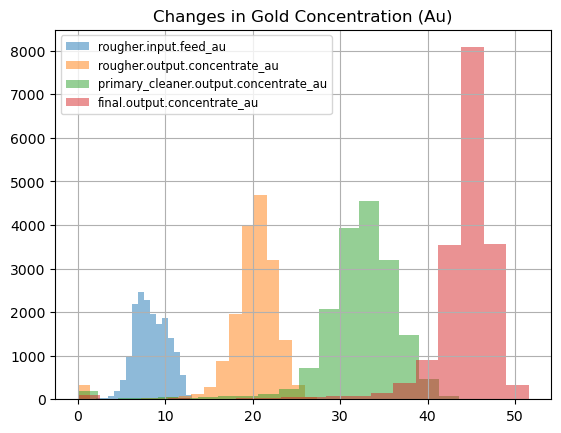

In [34]:
# Plotting purification progress of gold
purify_progress('au')
plt.title('Changes in Gold Concentration (Au)')

Text(0.5, 1.0, 'Changes in Silver Concentration (Ag)')

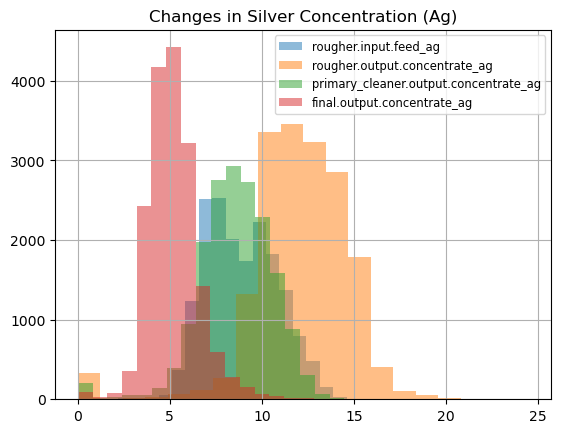

In [35]:
# Plotting purification progress for silver
purify_progress('ag')
plt.title('Changes in Silver Concentration (Ag)')

Text(0.5, 1.0, 'Changes in Lead Concentration (Pb)')

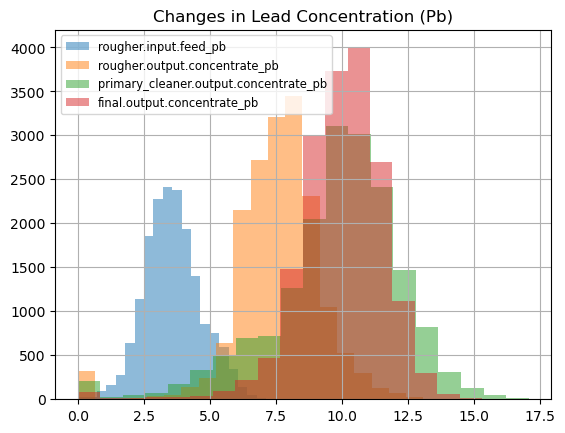

In [36]:
# Plotting purification progress of lead
purify_progress('pb')
plt.title('Changes in Lead Concentration (Pb)')

The graphs above illustrate a consistent rise in gold concentration during purification stages. Silver concentration decreases notably by the final stage, indicating effective removal. Lead concentration increases after the initial stages but stabilizes later. This suggests successful gold purification and possibly greater difficulty in eliminating lead compared to silver.

### 2.2. Compare the feed particle size distributions in the training set and in the test set.


In [37]:
train_updated['rougher.input.feed_size'].describe()

count    12168.000000
mean        57.758556
std         20.035191
min          9.659576
25%         48.424801
50%         54.069067
75%         62.292831
max        484.967466
Name: rougher.input.feed_size, dtype: float64

In [38]:
test_updated['rougher.input.feed_size'].describe()

count    5278.000000
mean       55.899020
std        19.002528
min         0.046369
25%        43.905687
50%        50.800105
75%        62.365410
max       392.494040
Name: rougher.input.feed_size, dtype: float64

In [39]:
rougher_input_train = train_updated['rougher.input.feed_size']
rougher_input_test = test_updated['rougher.input.feed_size']

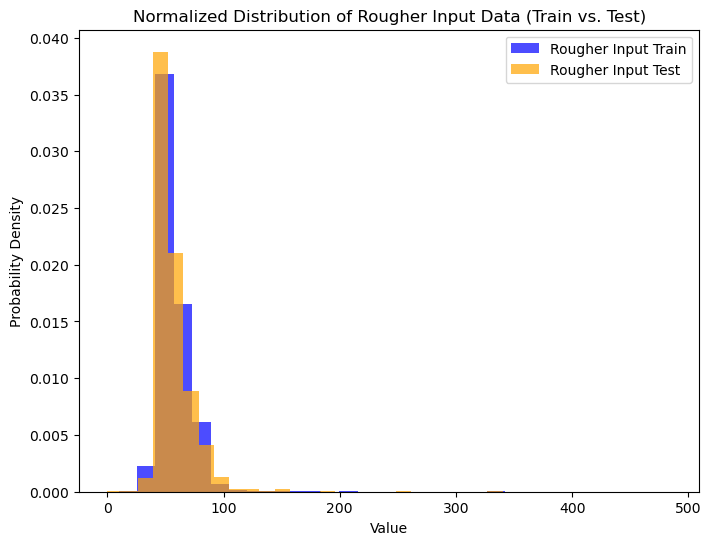

In [40]:
#Plotting normalized distribution of rougher input data
plt.figure(figsize=(8, 6))

plt.hist(rougher_input_train, bins=30, label='Rougher Input Train', alpha=0.7, density=True, color='blue')
plt.hist(rougher_input_test, bins=30, label='Rougher Input Test', alpha=0.7, density=True, color='orange')

plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Normalized Distribution of Rougher Input Data (Train vs. Test)')

plt.legend(loc='upper right')

plt.show()


In [41]:
# Combine the two series into a DataFrame
combined = pd.concat([rougher_input_train, rougher_input_test], axis = 1)
combined.columns=['Train Input Feedsize', 'Test Input Feedsize']

Text(0.5, 1.0, 'Comparison of Input Feedsize\nBetween Two Datasets')

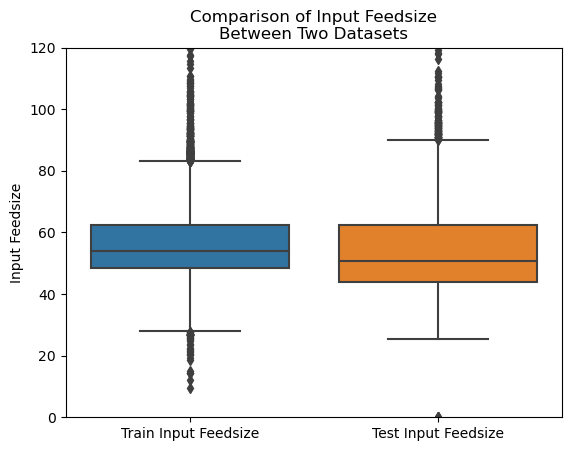

In [42]:
# Boxplot of the combined dataset
sns.boxplot(combined)
plt.ylim(0, 120)
plt.ylabel('Input Feedsize')
plt.title('Comparison of Input Feedsize\nBetween Two Datasets')

**Median (Center Line)** The horizontal line inside each box represents the median input feed size for each dataset. In this case, it appears that the median feed size is similar for both datasets, as the lines are at approximately the same level.

**Box (Interquartile Range - IQR):** The box itself represents the interquartile range, which contains the middle 50% of the data. The height of the box indicates the spread of the data. In this graph, the boxes have similar heights, suggesting that the variability in input feed sizes is consistent between the two datasets.

**Whiskers:** The lines extending from the boxes (whiskers) indicate the range of the data, excluding any outliers. It seems that both datasets have similar whisker lengths, indicating a comparable spread of values.

**Outliers:** Individual data points outside the whiskers are considered outliers. 

Overall, the boxplot suggests that the input feed sizes in the two datasets are similar in terms of median values, spread, and the presence of outliers. This information can be valuable for comparing and understanding the distribution of this particular feature between the two datasets.

#### 2.3. Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate.

In [43]:
# Create input columns
input = ['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol', 'rougher.input.feed_au']

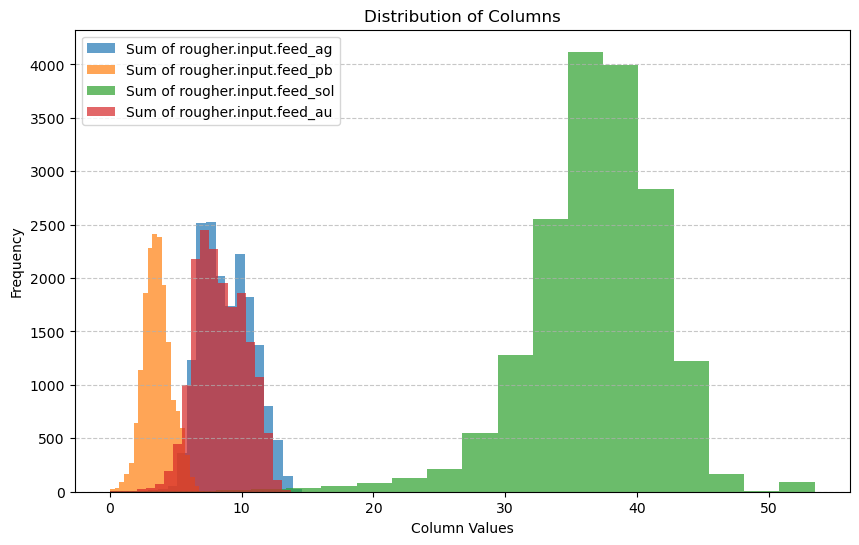

In [44]:
# Plot Distribution of Columns
plt.figure(figsize=(10, 6))  

for col in input:
    plt.hist(full[col], bins=20, alpha=0.7, label=f'Sum of {col}')

plt.xlabel('Column Values')
plt.ylabel('Frequency')
plt.title('Distribution of Columns')

plt.legend()

plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.show()


<Axes: >

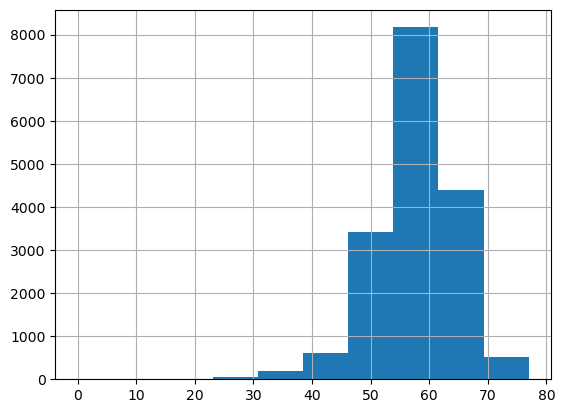

In [45]:
# Plot histogram of Sum of Input Feed
full[input].sum(axis=1).hist()

In [46]:
# Create output columns
output = ['rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 
          'rougher.output.concentrate_sol', 'rougher.output.concentrate_au']

<Axes: >

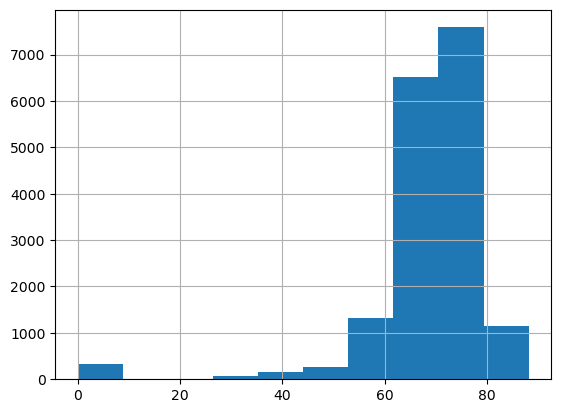

In [47]:
# Plot histogram of output columns
full[output].sum(axis=1).hist()

In [48]:
# Create final columns
final = ['final.output.concentrate_ag', 'final.output.concentrate_pb', 
          'final.output.concentrate_sol', 'final.output.concentrate_au']

<Axes: >

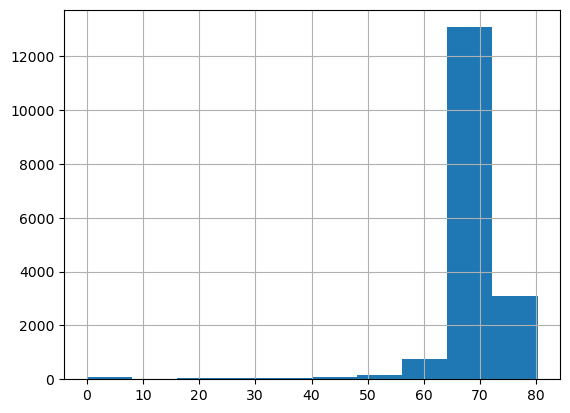

In [49]:
# Plot histogram of final columns
full[final].sum(axis=1).hist()

The histograms presented above reveal that although there are occasional anomalies with values near or at zero, their overall prevalence is relatively low. This can be attributed to thorough preprocessing steps, including the removal of rows containing missing values. Given the infrequent occurrence of these anomalies, it is improbable that they will have not have substantial impact on future analyses or outcomes.

## 3. Build the model

### 3.1. Write a function to calculate the final sMAPE value.

In [50]:
# Define sMAPE function
def smape(target, prediction): 
    return (1/len(target)) * sum(abs(prediction - target) / ((abs(target) + abs(prediction)) / 2) * 100)

In [51]:
# Defining final_smape function
def final_smape(target, prediction):
    rougher = smape(target[:, 0], prediction[:, 0])
    final = smape(target[:, 1], prediction[:, 1])
    return rougher * 0.25 + final * 0.75

### 3.2. Train different models. 

In [52]:
# Remove columns that are not in the test set
train_updated_features = train_updated[train_updated.columns.difference(column_differences)]
train_updated_features.drop('date', axis=1, inplace=True)

In [53]:
# Create train target
train_updated_target = train_updated[['rougher.output.recovery', 'final.output.recovery']].copy()

In [54]:
# Set sMAPE as the scoring function
smape_score = make_scorer(final_smape, greater_is_better=False)

In [55]:
# Save the features and target variables to separate variables
x_train = train_updated_features.values
y_train = train_updated_target.values

### 3.3. Evaluate models using cross-validation. Pick the best model and test it using the test sample.

In [56]:
# Train Linear Regression Model and calculate sMAPE score with cross validation
lr = LinearRegression().fit(x_train, y_train)
scores_lr = cross_val_score(lr, x_train, y_train, cv=5, scoring=smape_score)
print("Mean sMAPE:", np.nanmean(scores_lr))
print("score_lr:", scores_lr)

Mean sMAPE: -11.832254325922207
score_lr: [-12.4758322  -10.14104266 -11.91609544 -13.71780766 -10.91049367]


In [57]:
# Train Decision Tree Regressor Model and calculate sMAPE score with cross validation
dtr = DecisionTreeRegressor(random_state=random_state).fit(x_train, y_train)
scores_dtr = cross_val_score(dtr, x_train, y_train, cv=5, scoring=smape_score)
print("Mean sMAPE:", np.nanmean(scores_dtr))
print("scores_dtr:", scores_dtr)

Mean sMAPE: -20.446700714454202
scores_dtr: [-20.2215614           nan          nan          nan -20.67184003]


In [58]:
# Train Random Forest Regressor Model and calculate sMAPE score with cross validation
for depth in range(1,6): 
    rfr = RandomForestRegressor(n_estimators = 50, max_depth=depth, random_state=
                                random_state).fit(x_train, y_train)
    scores_rfr = cross_val_score(rfr, x_train, y_train, cv=5, scoring=smape_score)
    print("Depth: ", depth, "Mean sMAPE:", np.nanmean(scores_rfr))
    print("Cross validation scores: ", scores_rfr)
    print()

Depth:  1 Mean sMAPE: -10.435227904044547
Cross validation scores:  [-10.54681987 -10.27158003 -10.09525907 -10.10905619 -11.15342436]

Depth:  2 Mean sMAPE: -10.30777639307692
Cross validation scores:  [ -9.91012328  -9.38471591 -10.92254569 -10.78371918 -10.5377779 ]

Depth:  3 Mean sMAPE: -10.339383895947728
Cross validation scores:  [ -9.96429541  -9.2429181  -10.93366678 -11.40616364 -10.14987555]

Depth:  4 Mean sMAPE: -10.273678335366352
Cross validation scores:  [-10.35223358  -9.14051358 -10.71080502 -11.34866609  -9.81617341]

Depth:  5 Mean sMAPE: -10.10982695032888
Cross validation scores:  [-10.31480461  -9.21372167 -10.12683841 -11.12315418  -9.77061587]



In [59]:
# Setting test features by removing the 'date' column and converting to a NumPy array
x_test = test_updated.drop('date', axis=1, inplace=False).values

In [60]:
# Merge test dataset with full to get target values
test_updated = test_updated.merge(full[['final.output.recovery', 'rougher.output.recovery', 'date']], 
                                        how='left', on='date')

In [61]:
print(test_updated.columns)

Index(['date', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_au', 'rougher.input.feed_pb',
       'rougher.input.feed_rate', 'rougher.input.feed_size',
       'rougher.input.feed_sol', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'roughe

In [62]:
# Drop rows in the test set where the target variables have missing values
test_updated = test_updated.dropna(subset=['rougher.output.recovery', 'final.output.recovery'])

# Creating y_test from the updated test set and converting into a NumPy array
y_test = test_updated[['rougher.output.recovery', 'final.output.recovery']].values

In [63]:
# Train Dummy Regressor Model and check sMAPE score
dm = DummyRegressor(strategy='median').fit(x_train, y_train)
y_pred_baseline = dm.predict(x_test[:len(y_test)])  
print('Baseline sMAPE:', final_smape(y_test, y_pred_baseline))

Baseline sMAPE: 9.419950273773068


In [64]:
# Create and train a Random Forest Regressor model
rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(x_train, y_train)  # Use x_train and y_train here

# Make predictions using the Random Forest Regressor model
y_pred_rf = rf_regressor.predict(x_test)

# Handle missing values in y_test
valid_indices = ~np.isnan(y_test[:, 0]) & ~np.isnan(y_test[:, 1])
y_test_valid = y_test[valid_indices]
y_pred_rf_valid = y_pred_rf[:len(y_test)][valid_indices]

smape_score_rf = final_smape(y_test_valid, y_pred_rf_valid)
print('sMAPE (Random Forest Regressor):', smape_score_rf)


sMAPE (Random Forest Regressor): 11.270081553781658


## Conclusion
The best model for predicting the recovery rate of gold from gold ore is the Random Forest Regressor Model. The model achieved the best sMAPE score among all the models, indicating superior predictive performance. While the Decision Tree Regressor Model also performed well, the Random Forest Regressor Model outperformed it with a lower sMAPE score of 11.270081553781658. However, it's worth noting that the Random Forest Regressor Model took longer to run due to its complexity, but in the deployed model, we mostly care about prediction time, not training time.

After creating and training the Random Forest Regressor model, we applied it to make predictions on the test data while handling missing values appropriately. By excluding data points with missing target values and evaluating the model on a valid subset, we obtained a reliable sMAPE score.

The sMAPE score for the Random Forest Regressor Model further confirms its success. However, it's essential to address the observation that our best model performed worse than the constant baseline. Several factors could contribute to this, such as data quality issues, or the presence of hidden variables that we don't have access to, influencing the target variable. While the Random Forest Regressor Model demonstrated better predictive power, the challenges in achieving accurate predictions indicate the need for further investigation and data refinement to enhance model performance. Considering both predictive accuracy and computational efficiency, the Random Forest Regressor Model remains the preferred choice for predicting the recovery rate of gold from gold ore, but further efforts should be directed toward refining the model and data collection processes to improve its reliability.